<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

### Задача определения частей речи, Part-Of-Speech Tagger (POS)

**UPD**: torchtext.legacy доступен с версией torchtext=0.9, который понижает версию torch до 1.8.0. Вероятно, это вызывает конфликт с cuda версии 11.2, потому что модель на cuda не переводится (сыпались разные ошибки). У меня не получилось установить неконфиктующие версии, поэтому я установила torchtext версии 0.8, как в предыдущей домашней работе (это версия до перевода Field и прочего в legacy)

In [1]:
!pip install torchtext==0.8

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.9 MB 20.9 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.1
    Uninstalling torchtext-0.13.1:
      Successfully uninstalled torchtext-0.13.1


Мы будем решать задачу определения частей речи (POS-теггинга) с помощью скрытой марковской модели (HMM).

In [2]:
import nltk
import pandas as pd
import numpy as np
from collections import OrderedDict, deque, Counter
from nltk.corpus import brown
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings("ignore") 

Вам в помощь http://www.nltk.org/book/

Загрузим brown корпус

In [4]:
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

Существует множество наборов грамматических тегов, или тегсетов, например:
* НКРЯ
* Mystem
* UPenn
* OpenCorpora (его использует pymorphy2)
* Universal Dependencies

<b>Существует не одна система тегирования, поэтому будьте внимательны, когда прогнозируете тег слов в тексте и вычисляете качество прогноза. Можете получить несправедливо низкое качество вашего решения.

На данный момент стандартом является **Universal Dependencies**. Подробнее про проект можно почитать [вот тут](http://universaldependencies.org/), а про теги — [вот тут](http://universaldependencies.org/u/pos/)

In [5]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

<img src="https://4.bp.blogspot.com/-IcFli2wljs0/WrVCw3umY_I/AAAAAAAACYM/UJ_neoUAs3wF95dj2Ouf3BzxXzB_b2TbQCLcBGAs/s1600/postags.png">


Мы имеем массив предложений пар (слово-тег)

In [6]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")
brown_tagged_sents

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

Первое предложение

In [7]:
brown_tagged_sents[0]

[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("Atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP'),
 ('any', 'DET'),
 ('irregularities', 'NOUN'),
 ('took', 'VERB'),
 ('place', 'NOUN'),
 ('.', '.')]

Все пары (слово-тег)

In [7]:
brown_tagged_words = brown.tagged_words(tagset='universal')
brown_tagged_words

[('The', 'DET'), ('Fulton', 'NOUN'), ...]

Проанализируйте данные, с которыми Вы работаете. Используйте `nltk.FreqDist()` для подсчета частоты встречаемости тега и слова в нашем корпусе. Под частой элемента подразумевается кол-во этого элемента в корпусе.

In [8]:
# Приведем слова к нижнему регистру
brown_tagged_words = list(map(lambda x: (x[0].lower(), x[1]), brown_tagged_words))

In [10]:
print('Кол-во предложений: ', len(brown_tagged_sents))
tags = [tag for (word, tag) in brown_tagged_words] # наши теги
words = [word for (word, tag) in brown_tagged_words] # наши слова

tag_num = pd.Series(Counter(tags)).sort_values(ascending=False) # тег - кол-во тега в корпусе
word_num = pd.Series(Counter(words)).sort_values(ascending=False) # слово - кол-во слова в корпусе

Кол-во предложений:  57340


In [11]:
tag_num

NOUN    275558
VERB    182750
.       147565
ADP     144766
DET     137019
ADJ      83721
ADV      56239
PRON     49334
CONJ     38151
PRT      29829
NUM      14874
X         1386
dtype: int64

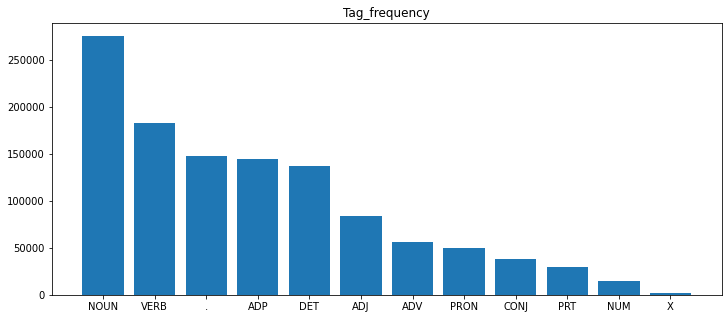

In [12]:
plt.figure(figsize=(12, 5))
plt.bar(tag_num.index, tag_num.values)
plt.title("Tag_frequency")
plt.show()

In [13]:
word_num[:5]

the    69971
,      58334
.      49346
of     36412
and    28853
dtype: int64

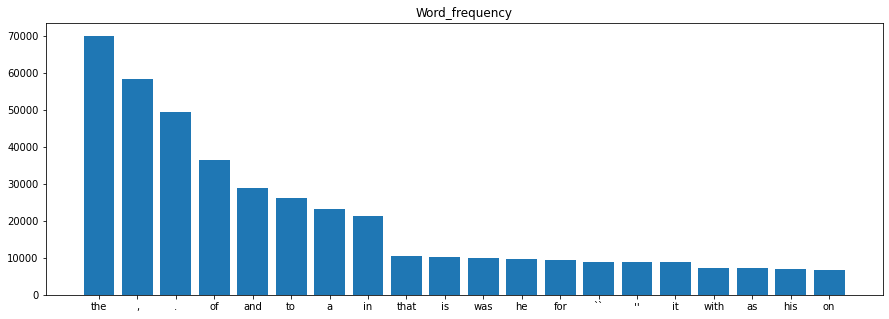

In [14]:
plt.figure(figsize=(15, 5))
plt.bar(word_num.index[:20], word_num.values[:20])
plt.title("Word_frequency")
plt.show()

### Вопрос 1:
* Кол-во слова `cat` в корпусе?

In [15]:
print(f"Слово cat встречается в корпусе {word_num['cat']} раза")

Слово cat встречается в корпусе 23 раза


### Вопрос 2:
* Самое популярное слово с самым популярным тегом? <br>(*сначала выбираете слова с самым популярным тегом, а затем выбираете самое популярное слово из уже выбранных*)

In [16]:
pop_tag = tag_num.idxmax()
cand_words = pd.Series(Counter([word for (word, tag) in brown_tagged_words if tag == pop_tag]))

print('Самый популярный тег: ', pop_tag)
print('Самое популярное слово с самым популярным тегом: ', cand_words.idxmax())

Самый популярный тег:  NOUN
Самое популярное слово с самым популярным тегом:  time


Впоследствии обучение моделей может занимать слишком много времени, работайте с подвыборкой, например, только текстами определенных категорий.

Категории нашего корпуса:

In [17]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

Будем работать с категорией humor

Cделайте случайное разбиение выборки на обучение и контроль в отношении 9:1. 

In [9]:
brown_tagged_sents = brown.tagged_sents(tagset="universal", categories='humor')
# Приведем слова к нижнему регистру
my_brown_tagged_sents = []
for sent in brown_tagged_sents:
    my_brown_tagged_sents.append(list(map(lambda x: (x[0].lower(), x[1]), sent)))
my_brown_tagged_sents = np.array(my_brown_tagged_sents, dtype='object')

from sklearn.model_selection import train_test_split
train_sents, test_sents = train_test_split(my_brown_tagged_sents, train_size=0.9, random_state=0)

In [19]:
len(train_sents)

947

In [20]:
len(test_sents)

106

In [21]:
train_sents[0]

[('then', 'ADV'),
 (',', '.'),
 ('i', 'PRON'),
 ('remembered', 'VERB'),
 ('that', 'ADP'),
 ('the', 'DET'),
 ('girls', 'NOUN'),
 ('had', 'VERB'),
 ('had', 'VERB'),
 ('a', 'DET'),
 ('banana', 'NOUN'),
 ('for', 'ADP'),
 ('dessert', 'NOUN'),
 ('every', 'DET'),
 ('day', 'NOUN'),
 ('for', 'ADP'),
 ('the', 'DET'),
 ('last', 'ADJ'),
 ('week', 'NOUN'),
 ('.', '.')]

### Метод максимального правдоподобия для обучения модели

* $\normalsize S = s_0, s_1, ..., s_N$ - скрытые состояния, то есть различные теги
* $\normalsize O = o_0, o_1, ..., o_M$ - различные слова
* $\normalsize a_{i,j} = p(s_j|s_i)$ - вероятность того, что, находясь в скрытом состоянии $s_i$, мы попадем в состояние $s_j$ (элемент матрицы $A$)
* $\normalsize b_{k,j}=p(o_k|s_j)$ - вероятность того, что при скрытом состоянии $s_j$ находится слово $o_k$(элемент матрицы $B$)

$$\normalsize x_t \in O, y_t \in S$$
$\normalsize (x_t, y_t)$ - слово и тег, стоящие на месте $t$ $\Rightarrow$ 
* $\normalsize X$ - последовательность слов
* $\normalsize Y$ - последовательность тегов

Требуется построить скрытую марковскую модель (class HiddenMarkovModel) и написать метод fit для настройки всех её параметров с помощью оценок максимального правдоподобия по размеченным данным (последовательности пар слово+тег):

- Вероятности переходов между скрытыми состояниями $p(y_t | y_{t - 1})$ посчитайте на основе частот биграмм POS-тегов.


- Вероятности эмиссий наблюдаемых состояний $p(x_t | y_t)$ посчитайте на основе частот "POS-тег - слово".


- Распределение вероятностей начальных состояний $p(y_0)$ задайте равномерным.

Пример $X = [x_0, x_1], Y = [y_0, y_1]$:<br><br>
$$p(X, Y) = p(x_0, x_1, y_0, y_1) = p(y_0) \cdot p(x_0, x_1, y_1 | y_0) = p(y_0) \cdot p(x_0 | y_0) \cdot
p(x_1, y_1 | x_0, y_0) = \\ = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | x_0, y_0) \cdot p(x_1 | x_0, y_0, y_1)
= (\text{в силу условий нашей модели}) = \\ = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | y_0) \cdot p(x_1 | y_1) \Rightarrow$$ <br>
Для последовательности длины $n + 1$:<br>
$$p(X, Y) = p(x_0 ... x_{n - 1}, y_0 ... y_{n - 1}) \cdot p(y_n | y_{n - 1}) \cdot p(x_n | y_n)$$

#### Алгоритм Витерби для применения модели


Требуется написать метод .predict для определения частей речи на тестовой выборке. Чтобы использовать обученную модель на новых данных, необходимо реализовать алгоритм Витерби. Это алгоритм динамиеского программирования, с помощью которого мы будем находить наиболее вероятную последовательность скрытых состояний модели для фиксированной последовательности слов:

$$ \hat{Y} = \arg \max_{Y} p(Y|X) = \arg \max_{Y} p(Y, X) $$

Пусть $\normalsize Q_{t,s}$ - самая вероятная последовательность скрытых состояний длины $t$ с окончанием в состоянии $s$. $\normalsize q_{t, s}$ - вероятность этой последовательности.
$$(1)\: \normalsize q_{t,s} = \max_{s'} q_{t - 1, s'} \cdot p(s | s') \cdot p(o_t | s)$$
$\normalsize Q_{t,s}$ можно восстановить по argmax-ам.

In [22]:
from copy import deepcopy

class HiddenMarkovModel:    
    def __init__(self):
        
        pass
        
    def fit(self, train_tokens_tags_list):
        """
        train_tokens_tags_list: массив предложений пар слово-тег (выборка для train) 
        """
        tags = [tag for sent in train_tokens_tags_list
                for (word, tag) in sent]
        words = [word for sent in train_tokens_tags_list
                 for (word, tag) in sent]
        
        tag_num = pd.Series(Counter(tags)).sort_index()
        word_num = pd.Series(Counter(words)).sort_values(ascending=False)

        self.tags = tag_num.index
        self.words = word_num.index

        # pop_tag, pop_word
        pop_tag = tag_num.idxmax()

        cand_words = pd.Series(Counter([word for sent in train_tokens_tags_list 
                             for (word, tag) in sent if tag == pop_tag]))
        self.pop_tag = pop_tag
        self.pop_word = cand_words.idxmax()
                
        A = pd.DataFrame({'{}'.format(tag) : [0] * len(tag_num) for tag in tag_num.index}, index=tag_num.index)
        B = pd.DataFrame({'{}'.format(tag) : [0] * len(word_num) for tag in tag_num.index}, index=word_num.index)
        
        # Вычисляем матрицу A и B по частотам слов и тегов
        
        # sent - предложение
        # sent[i][0] - i слово в этом предложении, sent[i][1] - i тег в этом предложении
        for sent in train_tokens_tags_list:
            for i in range(len(sent)):
                B.loc[sent[i][0], sent[i][1]] += 1 # текущая i-пара слово-тег (обновите матрицу B аналогично A)
                if len(sent) - 1 != i: # для последнего тега нет следующего тега                    
                    A.loc[sent[i][1], sent[i + 1][1]] += 1 # пара тег-тег
                
        
        # переходим к вероятностям
        
        # нормируем по строке, то есть по всем всевозможным следующим тегам
        A = A.divide(A.sum(axis=1), axis=0)
        
        # нормируем по столбцу, то есть по всем всевозможным текущим словам
        B = B / np.sum(B, axis=0)
        
        self.A = A
        self.B = B
        
        return self
        
    
    def predict(self, test_tokens_list):
        """
        test_tokens_list : массив предложений пар слово-тег (выборка для test)
        """
        predict_tags = OrderedDict({i : np.array([]) for i in range(len(test_tokens_list))})
        
        for i_sent in range(len(test_tokens_list)):
            
            current_sent = deepcopy(test_tokens_list[i_sent]) # текущее предложение
            len_sent = len(current_sent) # длина предложения 
            
            q = np.zeros(shape=(len_sent + 1, len(self.tags)))
            q[0] = 1 # нулевое состояние (равномерная инициализация по всем s)
            back_point = np.zeros(shape=(len_sent + 1, len(self.tags))) # # argmax
            
            for t in range(len_sent):
                
                # если мы не встречали такое слово в обучении, то вместо него будет 
                # самое популярное слово с самым популярным тегом (вопрос 2)
                if current_sent[t] not in self.words:
                    current_sent[t] = self.pop_word
                    
                # через max выбираем следующий тег
                for i_s in range(len(self.tags)):
                    
                    s = self.tags[i_s]
                    
                    # формула (1)
                    tmp = q[t] * self.A.loc[:, s] * self.B.loc[current_sent[t], s]
                    q[t + 1][i_s] = np.max(tmp)
                    
                    # argmax формула(1)
                    
                    # argmax, чтобы восстановить последовательность тегов
                    back_point[t + 1][i_s] = tmp.reset_index()[s].idxmax() # индекс 
                    
            back_point = back_point.astype('int')
            
            # выписываем теги, меняя порядок на реальный
            back_tag = deque()
            current_tag = np.argmax(q[len_sent])
            for t in range(len_sent, 0, -1):
                back_tag.appendleft(self.tags[current_tag])
                current_tag = back_point[t, current_tag]
             
            predict_tags[i_sent] = np.array(back_tag)
        
        
        return predict_tags                 

Обучите скрытую марковскую модель:

In [23]:
HMM_model = HiddenMarkovModel()
HMM_model.fit(train_sents)

In [25]:
HMM_model.pop_tag, HMM_model.pop_word

('NOUN', 'time')

In [24]:
HMM_model.A.shape, HMM_model.B.shape

((12, 12), (4431, 12))

Проверьте работу реализованного алгоритма на следующих модельных примерах, проинтерпретируйте результат.

- 'He can stay'
- 'a cat and a dog'
- 'I have a television'
- 'My favourite character'

In [26]:
sents = [['He', 'can', 'stay'], ['a', 'cat', 'and', 'a', 'dog'], ['I', 'have', 'a', 'television'],
         ['My', 'favourite', 'character']]

'''your code'''
predict_tags = HMM_model.predict(sents)

In [27]:
predict_tags

OrderedDict([(0, array(['NOUN', 'VERB', 'VERB'], dtype='<U4')),
             (1, array(['DET', 'NOUN', 'CONJ', 'DET', 'NOUN'], dtype='<U4')),
             (2, array(['NOUN', 'VERB', 'DET', 'NOUN'], dtype='<U4')),
             (3, array(['NOUN', 'NOUN', 'NOUN'], dtype='<U4'))])

### Вопрос 3:
* Какой тег вы получили для слова `can`?

In [28]:
'''your code'''
word = 'can'
for ind, sent in enumerate(sents):
  if word in sent:
    ind0 = ind
    ind1 = sent.index(word)

print(f'Тег слова {word} = ', predict_tags[ind0][ind1])

Тег слова can =  VERB


### Вопрос 4:
* Какой тег вы получили для слова `favourite`?

In [29]:
'''your code'''
word = 'favourite'
for ind, sent in enumerate(sents):
  if word in sent:
    ind0 = ind
    ind1 = sent.index(word)

print(f'Тег слова {word} = ', predict_tags[ind0][ind1])

Тег слова favourite =  NOUN


Примените модель к отложенной выборке Брауновского корпуса и подсчитайте точность определения тегов (accuracy). Сделайте выводы. 

In [30]:
def accuracy_score(model, sents):
    true_pred = 0
    num_pred = 0

    for sent in sents:
        tags = [tag for (word, tag) in sent]
        words = [word for (word, tag) in sent]

        '''your code'''
        preds = model.predict([words])[0]

        true_pred += sum(preds == tags) 
        num_pred += len(tags) 
    print("Accuracy:", true_pred / num_pred * 100, '%')
    return true_pred / num_pred * 100

In [31]:
acc = accuracy_score(HMM_model, test_sents)

Accuracy: 88.82847256549678 %


### Вопрос 5:
* Какое качество вы получили(округлите до одного знака после запятой)?

In [32]:
print('Качество скрытой марковской модели на тестовой выборке = ', acc.round(1))

Качество скрытой марковской модели на тестовой выборке =  88.8


## DefaultTagger

### Вопрос 6:
* Какое качество вы бы получили, если бы предсказывали любой тег, как самый популярный тег на выборке train(округлите до одного знака после запятой)?

Вы можете испоьзовать DefaultTagger(метод tag для предсказания частей речи предложения)

In [33]:
from nltk.tag import DefaultTagger
pop_tag = HMM_model.pop_tag

default_tagger = DefaultTagger(pop_tag)

true_pred = 0
num_pred = 0
for sent in test_sents:
    tags = [tag for (word, tag) in sent]
    words = [word for (word, tag) in sent]

    words_tags = default_tagger.tag(words)
    lst_tags = [tag for (word, tag) in words_tags]

    true_pred += sum(np.array(lst_tags) == np.array(tags))
    num_pred += len(tags) 

acc = true_pred / num_pred * 100

print("Accuracy:", acc, '%')

Accuracy: 20.217498764211566 %


In [34]:
print('Качество DefaultTagger на тестовой выборке = ', acc.round(1))

Качество DefaultTagger на тестовой выборке =  20.2


А что если возвращать наиболее популярный тег из матрицы B? Если слово отсутствует, то берем самое популярное слово.

In [35]:
dct_pop_tags = dict()
for word in HMM_model.B.index:
  dct_pop_tags[word] = HMM_model.B.loc[word].idxmax()

true_pred = 0
num_pred = 0
for sent in test_sents:
    tags = [tag for (word, tag) in sent]
    words = [word for (word, tag) in sent]

    pred_tags = []
    for word in words:
      if word not in dct_pop_tags:
          pred_tags.append(HMM_model.pop_tag)
      else:
          pred_tags.append(dct_pop_tags[word])

    true_pred += sum(np.array(pred_tags) == np.array(tags))
    num_pred += len(tags) 

acc = true_pred / num_pred * 100

print("Accuracy:", acc, '%')

Accuracy: 88.18586258032624 %


Качество предсказаний незначительно отличается от скрытой марковской модели.

## NLTK, Rnnmorph

Вспомним первый [семинар](https://colab.research.google.com/drive/1FHZVU6yJT61J8w1hALno0stD4VU36rit?usp=sharing) нашего курса. В том семинаре мы с вами работали c некоторыми библиотеками.

Не забудьте преобразовать систему тэгов из `'en-ptb' в 'universal'` с помощью функции `map_tag` или используйте `tagset='universal'`

In [ ]:
# from nltk.tag.mapping import map_tag

In [36]:
import nltk
nltk.download('averaged_perceptron_tagger')
# nltk.pos_tag(..., tagset='universal')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [37]:
true_pred = 0
num_pred = 0
for sent in test_sents:
    tags = [tag for (word, tag) in sent]
    words = [word for (word, tag) in sent]

    pred_tags = [tag for (word, tag) in nltk.pos_tag(words, tagset='universal')]
    
    true_pred += sum(np.array(pred_tags) == np.array(tags))
    num_pred += len(tags) 

nltk_acc = true_pred / num_pred * 100

In [40]:
print(f'Accuracy nltk.pos_tag: {round(nltk_acc, 1)} %')

Accuracy nltk.pos_tag: 89.2 %


In [41]:
!pip install -q rnnmorph
from rnnmorph.predictor import RNNMorphPredictor
predictor = RNNMorphPredictor(language="en")

     |████████████████████████████████| 19.7 MB 204 kB/s 
     |████████████████████████████████| 55 kB 3.7 MB/s 
     |████████████████████████████████| 8.2 MB 42.6 MB/s 


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [43]:
# need for RNNMorphPredictor
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [44]:
true_pred = 0
num_pred = 0
for sent in test_sents:
    tags = [tag for (word, tag) in sent]
    words = [word for (word, tag) in sent]

    pred_tags = [row.pos for row in predictor.predict(words)]
    
    true_pred += sum(np.array(pred_tags) == np.array(tags))
    num_pred += len(tags) 

rnn_acc = true_pred / num_pred * 100

from IPython.display import clear_output
clear_output()

In [46]:
print(f'Accuracy RNNMorphPredictor: {round(rnn_acc, 1)} %')

Accuracy RNNMorphPredictor: 62.8 %


### Вопрос 7:
* Какое качество вы получили, используя каждую из двух библиотек? Сравните их результаты.

* Качество с библиотекой rnnmorph должно быть хуже, так как там используется немного другая система тэгов. Какие здесь отличия?

In [45]:
print('Качество nltk на тестовой выборке = ', nltk_acc.round(2))
print('Качество RNNMorphPredictor на тестовой выборке = ', rnn_acc.round(2))

Качество nltk на тестовой выборке =  89.22
Качество RNNMorphPredictor на тестовой выборке =  62.83


In [47]:
# Низкое качество RNNMorphPredictor не кажется случайностью
# Посмотрим, на каких тэгах RNNMorphPredictor ошибается

dict_wrong = dict()

for sent in test_sents:
    tags = [tag for (word, tag) in sent]
    words = [word for (word, tag) in sent]

    pred_tags = [row.pos for row in predictor.predict(words)]

    for ind, val in enumerate(tags):
        if val not in dict_wrong:
          dict_wrong[val] = []
        dict_wrong[val].append(pred_tags[ind])

from IPython.display import clear_output
clear_output()

In [48]:
for key in dict_wrong.keys():
  dict_wrong[key] = Counter(dict_wrong[key])

In [49]:
dict_wrong.keys()

dict_keys(['.', 'VERB', 'ADJ', 'PRT', 'CONJ', 'ADV', 'ADP', 'DET', 'NOUN', 'NUM', 'PRON', 'X'])

In [50]:
pd.DataFrame(dict_wrong)

,.,VERB,ADJ,PRT,CONJ,ADV,ADP,DET,NOUN,NUM,PRON,X
PUNCT,345.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VERB,NaN,207.0,2.0,1.0,NaN,NaN,2.0,NaN,10.0,NaN,NaN,1.0
AUX,NaN,91.0,NaN,2.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
ADJ,NaN,7.0,113.0,1.0,NaN,4.0,NaN,NaN,16.0,3.0,NaN,2.0
NOUN,NaN,8.0,8.0,2.0,NaN,4.0,NaN,NaN,369.0,1.0,2.0,7.0
ADV,NaN,4.0,2.0,8.0,1.0,87.0,2.0,NaN,3.0,1.0,NaN,NaN
PART,NaN,NaN,NaN,21.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN
ADP,NaN,NaN,NaN,8.0,NaN,1.0,186.0,NaN,NaN,NaN,NaN,NaN
DET,NaN,NaN,NaN,4.0,NaN,NaN,1.0,183.0,NaN,NaN,NaN,NaN
PRON,NaN,NaN,NaN,6.0,NaN,NaN,2.0,50.0,6.0,1.0,117.0,NaN


В стобцах теги RNNMorph, в строках теги, которые нужно было предсказать.

Проанализируем результаты:

В стобцах теги RNNMorph, в строках теги, которые нужно было предсказать.

Проанализируем результаты:
---

* $.$ -> PUNCT (категория $.$ отсутствует в rnnmorph)
* VERB -> VERB (и 29% слов получают от rnnmorph тег AUX)
* ADJ -> ADJ
* PRT -> PART (категория PRT отсутствует в rnnmorph и не однозначно соответствует PART, имея довольно широкую дисперсию)
* CONJ -> CCONJ (категория CONJ отсутствует в rnnmorph)
* ADV -> ADV
* ADP -> ADP (и 10% слов получают от rnnmorph тег SCONJ)
* DET -> DET (и 21% слов получают от rnnmorph тег PRON)
* NOUN -> NOUN
* NUM -> NUM
* PRON -> PRON
* X -> NOUN (не смотря на то, что в rnnmorph есть тег X)


Кроме того PUNCT, AUX, PART, INTJ, CCONJ, SCONJ, PROPN присутствуют в rnnmorph, но отсутствуют в nltk


## BiLSTMTagger

### Подготовка данных

Изменим структуру данных

In [10]:
pos_data = [list(zip(*sent)) for sent in brown_tagged_sents]
print(pos_data[0])

[('It', 'was', 'among', 'these', 'that', 'Hinkle', 'identified', 'a', 'photograph', 'of', 'Barco', '!', '!'), ('PRON', 'VERB', 'ADP', 'DET', 'ADP', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', '.', '.')]


До этого мы писали много кода сами, теперь пора эксплуатировать pytorch

In [11]:
try:
  from torchtext.data import Field, BucketIterator, Example, Dataset  
except OSError:
  from torchtext.data import Field, BucketIterator, Example, Dataset
  

# наши поля
WORD = Field(lower=True)
TAG = Field(unk_token=None) # все токены нам извсетны

# создаем примеры
examples = []
for words, tags in pos_data:
    examples.append(Example.fromlist([list(words), list(tags)], fields=[('words', WORD), ('tags', TAG)]))

Вот один наш пример:

In [12]:
print(vars(examples[0]))

{'words': ['it', 'was', 'among', 'these', 'that', 'hinkle', 'identified', 'a', 'photograph', 'of', 'barco', '!', '!'], 'tags': ['PRON', 'VERB', 'ADP', 'DET', 'ADP', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', '.', '.']}


Теперь формируем наш датасет

In [14]:
# кладем примеры в наш датасет
dataset = Dataset(examples, fields=[('words', WORD), ('tags', TAG)])

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.1, 0.1])

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 842
Number of validation examples: 106
Number of testing examples: 105


Построим словари. Параметр `min_freq` выберете сами. При построении словаря испольузем только **train**

In [15]:
WORD.build_vocab(train_data, min_freq=1)
TAG.build_vocab(train_data)

print(f"Unique tokens in source (ru) vocabulary: {len(WORD.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TAG.vocab)}")

print(WORD.vocab.itos[::200])
print(TAG.vocab.itos)

Unique tokens in source (ru) vocabulary: 4218
Unique tokens in target (en) vocabulary: 13
['<unk>', 'thought', 'answered', 'former', 'built', 'journalism', 'siamese', 'allah', 'blue', 'collapse', 'dentist', 'equivalent', "general's", 'included', 'lionized', 'nearby', 'picasso', 'red-blooded', 'sensation', 'stretched', 'ugly', 'wyoming']
['<pad>', 'NOUN', 'VERB', '.', 'DET', 'ADP', 'ADJ', 'PRON', 'ADV', 'CONJ', 'PRT', 'NUM', 'X']


In [16]:
print(vars(train_data.examples[9]))

{'words': ['she', 'was', 'rollickingly', 'happy', '.'], 'tags': ['PRON', 'VERB', 'ADV', 'ADJ', '.']}


Посмотрим с насколько большими предложениями мы имеем дело

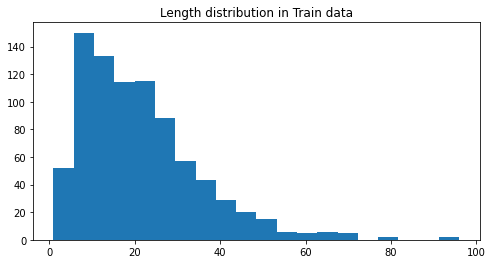

In [17]:
length = map(len, [vars(x)['words'] for x in train_data.examples])

plt.figure(figsize=[8, 4])
plt.title("Length distribution in Train data")
plt.hist(list(length), bins=20);

Для обучения `BiLSTM` лучше использовать colab

In [18]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [19]:
!nvidia-smi

Sat Nov 12 10:57:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Для более быстрого и устойчивого обучения сгруппируем наши данные по батчам

In [21]:
# бьем нашу выборку на батч, не забывая сначала отсортировать выборку по длине
def _len_sort_key(x):
    return len(x.words)

BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [22]:
# посморим  на количество батчей
list(map(len, [train_iterator, valid_iterator, test_iterator]))

[27, 4, 4]

### Модель и её обучение

Инициализируем нашу модель

In [23]:
class LSTMTagger(nn.Module):

    def __init__(self, vocab_size, emb_dim, hid_dim, output_dim, lstm_dropout, nn_dropout, n_layers, pad_idx, bidirectional=False):
        super().__init__()
        
  
        self.embeddings = nn.Embedding(vocab_size, emb_dim, padding_idx = pad_idx)
        self.dropout = nn.Dropout(p=nn_dropout)
        
        self.rnn = nn.LSTM(input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            bias=True,
            dropout=lstm_dropout,
            bidirectional=bidirectional
        )
        # если bidirectional, то предсказываем на основе конкатенации двух hidden
        self.tag = nn.Linear((1 + bidirectional) * hid_dim, output_dim)

    def forward(self, sent):
        
        #sent = [sent len, batch size] 
        
        # не забываем применить dropout к embedding
        embedded = self.dropout(self.embeddings(sent))

        output, _ = self.rnn(embedded)
        #output = [sent len, batch size, hid dim * n_directions]

        prediction = self.tag(output)
    
        return prediction
        
# параметры модели
vocab_size = len(WORD.vocab)
OUTPUT_DIM = len(TAG.vocab)
EMB_DIM = 300
HID_DIM = 256
LSTM_DROPOUT = 0.4
NN_DROPOUT = 0.4
n_layers = 2
BIDIRECTIONAL = True
PAD_IDX_emb = WORD.vocab.stoi[WORD.pad_token]

model = LSTMTagger(vocab_size, EMB_DIM, HID_DIM, OUTPUT_DIM, LSTM_DROPOUT, NN_DROPOUT, n_layers, PAD_IDX_emb, bidirectional=BIDIRECTIONAL)
model = model.to(device)

# инициализируем веса
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

LSTMTagger(
  (embeddings): Embedding(4218, 300, padding_idx=1)
  (dropout): Dropout(p=0.4, inplace=False)
  (rnn): LSTM(300, 256, num_layers=2, dropout=0.4, bidirectional=True)
  (tag): Linear(in_features=512, out_features=13, bias=True)
)

Подсчитаем количество обучаемых параметров нашей модели

In [24]:
def count_parameters(model, trainable=True):
    if trainable:
       return sum(p.numel() for p in model.parameters() if p.requires_grad)
    return sum(p.numel() for p in model.parameters())

print(f'The model has {count_parameters(model):,} trainable parameters')
print(f'The model has {count_parameters(model, False):,} parameters')

The model has 3,991,813 trainable parameters
The model has 3,991,813 parameters


Погнали обучать

In [25]:
PAD_IDX = TAG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):        
        input = batch.words.to(device)
        tags = batch.tags.to(device)        
        optimizer.zero_grad()        
        output = model(input)
        
        #tags = [sent len, batch size]
        #output = [sent len, batch size, output dim]
        
        output = output.flatten(0,1)
        # tags = tags.view(-1)
        tags = tags.flatten()
        
        #tags = [sent len * batch size]
        #output = [sent len * batch size, output dim]
        
        loss = criterion(output, tags)        
        loss.backward()
        
        # Gradient clipping(решение проблемы взрыва граденты), clip - максимальная норма вектора
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)        
        optimizer.step()        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()            
            plt.show()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()    
    epoch_loss = 0    
    history = []    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):
            input = batch.words.to(device)
            tags = batch.tags.to(device) 

            output = model(input)

            #tags = [sent len, batch size]
            #output = [sent len, batch size, output dim]

            output = output.flatten(0,1)
            # tags = tags.view(-1)
            tags = tags.flatten()
            #tags = [sent len * batch size]
            #output = [sent len * batch size, output dim]

            loss = criterion(output, tags)            
            epoch_loss += loss.item()        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

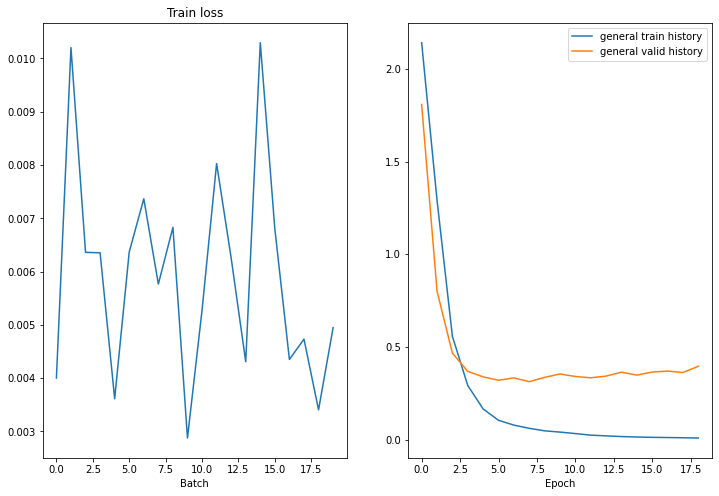

Epoch: 20 | Time: 0m 0s
	Train Loss: 0.006 | Train PPL:   1.006
	 Val. Loss: 0.396 |  Val. PPL:   1.485


In [26]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

train_history = []
valid_history = []

N_EPOCHS = 20
CLIP = 2

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):    
    start_time = time.time()    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

### Применение модели

In [27]:
def accuracy_model(model, iterator):
    model.eval()    
    true_pred = 0
    num_pred = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            input = batch.words.to(device)
            tags = batch.tags.to(device) 

            output = model(input)

            output = output.argmax(2)
            tags = tags
            
            #output = [sent len, batch size]
            predict_tags = output.cpu().numpy()
            true_tags = tags.cpu().numpy()

            true_pred += np.sum((true_tags == predict_tags) & (true_tags != PAD_IDX))
            num_pred += np.prod(true_tags.shape) - (true_tags == PAD_IDX).sum()
        
    return round(true_pred / num_pred * 100, 3)

In [28]:
model.load_state_dict(torch.load('best-val-model.pt'))

<All keys matched successfully>

In [29]:
lstm_humor_acc = accuracy_model(model, test_iterator)
print("Accuracy:", lstm_humor_acc, '%')

Accuracy: 92.649 %


Вы можете улучшить качество, изменяя параметры модели. Но чтобы добиться нужного качества, вам неообходимо взять все выборку, а не только категорию `humor`.

In [56]:
# Загрузим все категории
brown_tagged_sents = brown.tagged_sents(tagset="universal")
# Приведем слова к нижнему регистру
my_brown_tagged_sents = []
for sent in brown_tagged_sents:
    my_brown_tagged_sents.append(list(map(lambda x: (x[0].lower(), x[1]), sent)))
my_brown_tagged_sents = np.array(my_brown_tagged_sents, dtype='object')

from sklearn.model_selection import train_test_split
train_sents, test_sents = train_test_split(my_brown_tagged_sents, train_size=0.9, random_state=0)

In [57]:
len(train_sents), len(test_sents)

(51606, 5734)

In [59]:
# Проверим качество на HiddenMarkov
HMM_model = HiddenMarkovModel()
HMM_model.fit(train_sents)

In [61]:
HMM_acc = accuracy_score(HMM_model, test_sents)

Accuracy: 96.26295331104619 %


In [62]:
# Проверим качество на LSTMTagger

# Переделаем формат данных
pos_data = [list(zip(*sent)) for sent in brown_tagged_sents]
print(pos_data[0])
WORD = Field(lower=True)
TAG = Field(unk_token=None)

# создаем примеры
examples = []
for words, tags in pos_data:
    examples.append(Example.fromlist([list(words), list(tags)], fields=[('words', WORD), ('tags', TAG)]))


# кладем примеры в наш датасет
dataset = Dataset(examples, fields=[('words', WORD), ('tags', TAG)])
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.1, 0.1])
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

# создадим словари (в сравнении с предыдущим результатом поменяем min_freq)
WORD.build_vocab(train_data, min_freq=3)
TAG.build_vocab(train_data)

print(f"Unique tokens in WORD vocabulary: {len(WORD.vocab)}")
print(f"Unique tokens in TAG vocabulary: {len(TAG.vocab)}")

print(WORD.vocab.itos[::200])
print(TAG.vocab.itos)

#  бьем нашу выборку на батч, не забывая сначала отсортировать выборку по длине
def _len_sort_key(x):
    return len(x.words)

BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

# посморим  на количество батчей
print('Кол-во батчей:', list(map(len, [train_iterator, valid_iterator, test_iterator])))

# параметры модели
vocab_size = len(WORD.vocab)
OUTPUT_DIM = len(TAG.vocab)
EMB_DIM = 300
HID_DIM = 256
LSTM_DROPOUT = 0.4
NN_DROPOUT = 0.4
n_layers = 2
BIDIRECTIONAL = True
PAD_IDX_emb = WORD.vocab.stoi[WORD.pad_token]

model = LSTMTagger(vocab_size, EMB_DIM, HID_DIM, OUTPUT_DIM, LSTM_DROPOUT, NN_DROPOUT, n_layers, PAD_IDX_emb, bidirectional=BIDIRECTIONAL)
model = model.to(device)

# инициализируем веса
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

# посчитаем количество обучаемых параметров
print(f'The model has {count_parameters(model):,} trainable parameters')

# оптимайзер и лосс
PAD_IDX = TAG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

[('The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'), ('DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.')]
Number of training examples: 45872
Number of validation examples: 5734
Number of testing examples: 5734
Unique tokens in WORD vocabulary: 18030
Unique tokens in TAG vocabulary: 13
['<unk>', 'something', 'economic', 'low', 'degree', 'caught', 'capital', 'address', 'mentioned', 'uses', 'informed', 'inner', 'containing', 'burned', 'noise', 'proposal', 'voices', 'sovereign', 'poured', 'fogg', 'pressed', '1948', 'balanced', 'bridget', 'access', 'saint', 'miller', 'denver', 'artificial', 'norman', 'bottles', 'mythological', 'behaved', 'mileage', 'acreage', 'gradient', 'sells', 

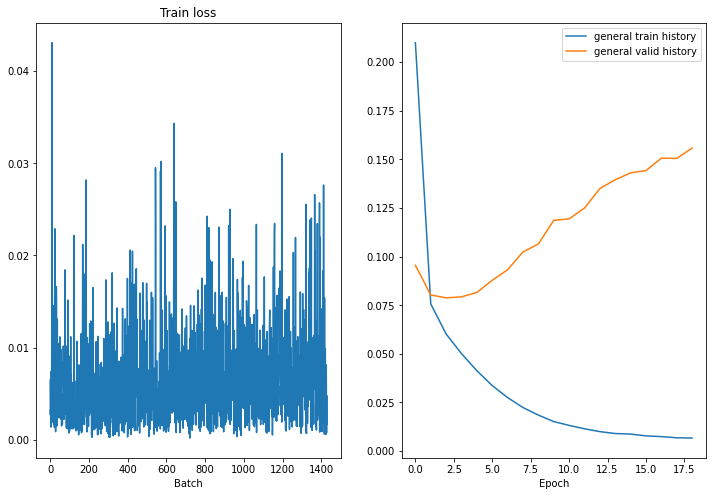

Epoch: 20 | Time: 1m 5s
	Train Loss: 0.006 | Train PPL:   1.006
	 Val. Loss: 0.159 |  Val. PPL:   1.172


In [63]:
# Обучим модель
train_history = []
valid_history = []

N_EPOCHS = 20
CLIP = 2

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):    
    start_time = time.time()    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [64]:
# Проверим accuracy
model.load_state_dict(torch.load('best-val-model.pt'))
print("Accuracy:", accuracy_model(model, test_iterator), '%')

Accuracy: 97.469 %


Вам неоходимо добиться качества не меньше, чем `accuracy = 93 %` 

In [65]:
best_model = LSTMTagger(vocab_size, EMB_DIM, HID_DIM, OUTPUT_DIM, LSTM_DROPOUT, NN_DROPOUT, n_layers, PAD_IDX_emb, bidirectional=BIDIRECTIONAL).to(device)
best_model.load_state_dict(torch.load('best-val-model.pt'))
assert accuracy_model(best_model, test_iterator) >= 93

Пример решение нашей задачи:

In [66]:
def print_tags(model, data):
    model.eval()
    
    with torch.no_grad():
        words, _ = data
        example = torch.LongTensor([WORD.vocab.stoi[elem] for elem in words]).unsqueeze(1).to(device)
        
        output = model(example).argmax(dim=-1).cpu().numpy()
        tags = [TAG.vocab.itos[int(elem)] for elem in output]

        for token, tag in zip(words, tags):
            print(f'{token:15s}{tag}')

In [67]:
print_tags(model, pos_data[-1])

From           VERB
what           DET
I              NOUN
was            VERB
able           ADJ
to             PRT
gauge          VERB
in             ADP
a              DET
swift          ADJ
,              .
greedy         ADJ
glance         NOUN
,              .
the            DET
figure         NOUN
inside         ADP
the            DET
coral-colored  NOUN
boucle         NOUN
dress          NOUN
was            VERB
stupefying     VERB
.              .


## Сравните результаты моделей HiddenMarkov, LstmTagger:
* при обучение на маленькой части корпуса, например, на категории humor
* при обучении на всем корпусе

Категория Humor:
* HiddenMarkov accuracy = 88.828%
* LstmTagger accuracy = 92.649%

Полный корпус:
* HiddenMarkov accuracy = 96.263%
* LstmTagger accuracy = 97.469%

LSTMTagger показывает лучше качество на меньших данных. И обе модели показывают сопоставимое качество на полном корпусе. Однако, на полном корпусе, LSTMTagger быстрее учится, и гораздо быстрее предсказывает.

LSTMTagger имеет возможности для настройки гиперпараметров, и, судя по графикам loss на обучении и валидации, можно повысить качество модели.

Вероятно, качество HiddenMarkov в большей степени зависит от размера train выборки. При переходе к полному корпусу, модель показала значительный прирост качества. LSTMTagger, напротив, показала значимый прирост качества, но все таки не такой существенный, как HiddenMarkov. Это может указывать на то, что LSTMTagger лучше понимает часть речи по предложению, чем HiddenMarkov. Полагаю, что использование моделей на другом корпусе, содержащем много неизвестных для моделей слов, окажет более существенное влияние на снижение качества HiddenMarkov.

**Подводим итог:**
* LstmTagger бысрее учится
* LstmTagger значительно быстрее предсказывает
* LstmTagger меньше зависит от размера обучающей выборки
* LstmTagger имеет возможности для повышения качества за счет настройки гиперпараметров